<h1 style="text-align: center;">SMT Challenge 2025 EDA</h1>
<h3 style="text-align: center;"><i>Team 15</i></h3>
<p style="text-align: center;">
    This notebook is used to explore the data given from the challenge and come up with the process to create necessary features
</p>

### Necessary Libraries

In [1]:
import pandas as pd
import pyarrow.dataset as pads
import pyarrow as pa
import os
import duckdb as db
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', None)

## Loading in the data
* These being `player_pos`, `rosters`, `game_events`, `ball_pos`, and `game_info`

In [3]:
con = db.connect("/Users/buttz/Desktop/SMTChallenge2025/smt_2025.db")

In [5]:
# This query takes awhile just because there's so many rows for each timestamp and there are lots of timestamps ~18 million rows
# I'm only curious in looking at the outfielders' positions --> yes that means i'm ignoring plays where the infielder will go into the outfield (e.g., for a popfly)
player_pos = con.execute("SELECT * FROM player_pos WHERE player_position IN (7, 8, 9)").df().copy()
display(player_pos.shape)
player_pos

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

(18132330, 10)

,game_str,play_id,timestamp,player_position,field_x,field_y,home_team,away_team,year,day
0,y1_d069_ACN_QEA,1,14853,7,-142.9887,249.6216,QEA,ACN,year_1,day_069
1,y1_d069_ACN_QEA,1,14853,8,-6.7491,313.4958,QEA,ACN,year_1,day_069
2,y1_d069_ACN_QEA,1,14853,9,122.9529,261.3693,QEA,ACN,year_1,day_069
3,y1_d069_ACN_QEA,1,14903,7,-142.9800,249.6138,QEA,ACN,year_1,day_069
4,y1_d069_ACN_QEA,1,14903,8,-6.7491,313.4958,QEA,ACN,year_1,day_069
...,...,...,...,...,...,...,...,...,...,...
18132325,y1_d058_WZR_YJD,330,12032975,8,-13.1577,216.3279,YJD,WZR,year_1,day_058
18132326,y1_d058_WZR_YJD,330,12032975,9,94.3239,194.6700,YJD,WZR,year_1,day_058
18132327,y1_d058_WZR_YJD,330,12033008,7,-65.5203,204.8616,YJD,WZR,year_1,day_058
18132328,y1_d058_WZR_YJD,330,12033008,8,-13.1823,216.4344,YJD,WZR,year_1,day_058


In [6]:
rosters = con.execute("SELECT * FROM rosters").df().copy()
display(rosters.shape)
rosters.head()

(143, 5)

,DYE,OXG,QEA,RZQ,YJD
0,DYE-0009,OXG-0018,QEA-0008,RZQ-0003,YJD-0001
1,DYE-0012,OXG-0029,QEA-0010,RZQ-0004,YJD-0002
2,DYE-0015,OXG-0052,QEA-0013,RZQ-0005,YJD-0007
3,DYE-0022,OXG-0054,QEA-0027,RZQ-0006,YJD-0011
4,DYE-0023,OXG-0061,QEA-0039,RZQ-0014,YJD-0016


In [7]:
game_events = con.execute("SELECT * FROM game_events").df().copy()
display(game_events.shape)
game_events.head()

(301314, 11)

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,home_team,away_team,year,day
0,y1_d069_ACN_QEA,1,1,1,14853,1,1,QEA,ACN,year_1,day_069
1,y1_d069_ACN_QEA,1,1,1,15303,2,2,QEA,ACN,year_1,day_069
2,y1_d069_ACN_QEA,1,1,1,15303,0,5,QEA,ACN,year_1,day_069
3,y1_d069_ACN_QEA,2,1,2,27753,1,1,QEA,ACN,year_1,day_069
4,y1_d069_ACN_QEA,2,1,2,28253,2,2,QEA,ACN,year_1,day_069


In [8]:
ball_pos = con.execute("SELECT * FROM ball_pos").df().copy()
display(ball_pos.shape)
ball_pos.head()

(2303284, 10)

,game_str,play_id,timestamp,ball_position_x,ball_position_y,ball_position_z,home_team,away_team,year,day
0,y1_d069_ACN_QEA,1,14853,3.500460,52.04430,5.71419,QEA,ACN,year_1,day_069
1,y1_d069_ACN_QEA,1,14903,3.210720,45.69720,5.54322,QEA,ACN,year_1,day_069
2,y1_d069_ACN_QEA,1,14953,2.929950,39.41790,5.31909,QEA,ACN,year_1,day_069
3,y1_d069_ACN_QEA,1,15003,2.658168,33.20670,5.04180,QEA,ACN,year_1,day_069
4,y1_d069_ACN_QEA,1,15053,2.395365,27.06366,4.71132,QEA,ACN,year_1,day_069


In [9]:
game_info = con.execute("SELECT * FROM game_info").df().copy()
display(game_info.shape)
game_info

(72566, 21)

,game_str,home_team,away_team,at_bat,play_per_game,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,year,day
0,y1_d069_ACN_QEA,QEA,ACN,1.0,1.0,top,QEA-0410,QEA-0071,QEA-0263,QEA-0277,QEA-0232,QEA-0027,QEA-0364,QEA-0365,QEA-0249,ACN-2455,NA,NA,NA,year_1,day_069
1,y1_d069_ACN_QEA,QEA,ACN,1.0,2.0,top,QEA-0410,QEA-0071,QEA-0263,QEA-0277,QEA-0232,QEA-0027,QEA-0364,QEA-0365,QEA-0249,ACN-2455,NA,NA,NA,year_1,day_069
2,y1_d069_ACN_QEA,QEA,ACN,1.0,3.0,top,QEA-0410,QEA-0071,QEA-0263,QEA-0277,QEA-0232,QEA-0027,QEA-0364,QEA-0365,QEA-0249,ACN-2455,NA,NA,NA,year_1,day_069
3,y1_d069_ACN_QEA,QEA,ACN,2.0,4.0,top,QEA-0410,QEA-0071,QEA-0263,QEA-0277,QEA-0232,QEA-0027,QEA-0364,QEA-0365,QEA-0249,ACN-1416,NA,NA,NA,year_1,day_069
4,y1_d069_ACN_QEA,QEA,ACN,69.0,134.0,top,QEA-0410,QEA-0071,QEA-0263,QEA-0277,QEA-0232,QEA-0027,QEA-0364,QEA-0365,QEA-0249,ACN-1147,NA,NA,NA,year_1,day_069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72561,y1_d058_WZR_YJD,YJD,WZR,91.0,325.0,top,YJD-0157,YJD-0007,YJD-0373,YJD-0060,YJD-0284,YJD-0172,YJD-0398,YJD-0185,YJD-0340,WZR-1285,NA,NA,NA,year_1,day_058
72562,y1_d058_WZR_YJD,YJD,WZR,93.0,326.0,top,YJD-0157,YJD-0007,YJD-0373,YJD-0060,YJD-0284,YJD-0172,YJD-0398,YJD-0185,YJD-0340,WZR-1285,NA,NA,NA,year_1,day_058
72563,y1_d058_WZR_YJD,YJD,WZR,93.0,327.0,top,YJD-0157,YJD-0007,YJD-0373,YJD-0060,YJD-0284,YJD-0172,YJD-0398,YJD-0185,YJD-0340,WZR-1285,NA,NA,NA,year_1,day_058
72564,y1_d058_WZR_YJD,YJD,WZR,93.0,329.0,top,YJD-0157,YJD-0007,YJD-0373,YJD-0060,YJD-0284,YJD-0172,YJD-0398,YJD-0185,YJD-0340,WZR-1942,WZR-1285,NA,NA,year_1,day_058


## Messing with the tables and making them easier to work with

In [10]:
event_code_dict = {
    1: 'pitch',
    2: 'ball acquired',
    3: 'throw (ball-in-play)',
    4: 'ball hit into play',
    5: 'end of play',
    6: 'pickoff throw',
    7: 'ball acquired - unknown field position',
    8: 'throw (ball-in-play) - unknown field position',
    9: 'ball deflection',
    10: 'ball deflection off of wall',
    11: 'home run',
    16: 'ball bounce'
}

player_position_dict = {
    1: 'pitcher',
    2: 'catcher',
    3: 'first basemen',
    4: 'second basemen',
    5: 'third basemen',
    6: 'shortstop',
    7: 'left field',
    8: 'center field',
    9: 'right field',
    10: 'batter',
    11: 'runner on first base',
    12: 'runner on second base',
    13: 'runner on third base',
    255: 'ball event with no player (e.g., ball bounce)',
    14: 'home plate umpire',
    15: 'field umpire #1',
    16: 'field umpire #2',
    17: 'field umpire #3',
    18: 'first base coach',
    19: 'third base coach'
}

In [11]:
game_events.loc[:, 'event_code_name'] = game_events['event_code'].map(event_code_dict)
game_events.loc[:, 'player_position_name'] = game_events['player_position'].map(player_position_dict)

In [12]:
def player_pos_df_changer(df: pd.DataFrame) -> pd.DataFrame:
    """
    Decreases the amount of rows for player_pos by moving each player's position as a column instead of its own row for each timestamp.
    Makes it easier to work with player_pos --> easier to merge with others and see how each player (at each position) is moving at each timestamp for any given play.

    Arguments: Dataframe
    """
    df = df.copy()
    df = df.pivot(index=['game_str', 'play_id', 'timestamp'], columns='player_position').copy()
    df.columns = [f'{i[0]}_{i[1]}' for i in df.columns]
    df.columns = [i if i.startswith('field_x') or i.startswith('field_y') else i.rsplit('_', 1)[0] for i in df.columns]
    df = df.loc[:, ~df.columns.duplicated()].copy()
    df = df[['field_x_7', 'field_y_7',
             'field_x_8', 'field_y_8',
             'field_x_9', 'field_y_9']].copy()
    return df.reset_index()

In [13]:
# Gets it to around only 6 million rows (1/3 of the original player_pos df) --> takes around 5-6 min to load player_pos + transform it
player_pos_transformed = player_pos_df_changer(player_pos).copy()
player_pos_transformed

,game_str,play_id,timestamp,field_x_7,field_y_7,field_x_8,field_y_8,field_x_9,field_y_9
0,y1_d001_CGA_QEA,1,8699,-138.6321,230.9421,-31.1307,307.0320,109.1400,258.7404
1,y1_d001_CGA_QEA,1,8749,-138.5343,230.9007,-31.1985,306.8640,109.1367,258.6951
2,y1_d001_CGA_QEA,1,8799,-138.4380,230.8596,-31.2663,306.6960,109.1358,258.6498
3,y1_d001_CGA_QEA,1,8849,-138.3426,230.8182,-31.3341,306.5250,109.1370,258.6045
4,y1_d001_CGA_QEA,1,8899,-138.2490,230.7768,-31.4019,306.3570,109.1400,258.5595
...,...,...,...,...,...,...,...,...,...
6051002,y2_d099_YJD_RZQ,292,10147948,-111.0312,268.1436,-15.5784,308.7033,118.3521,257.0847
6051003,y2_d099_YJD_RZQ,292,10147998,-111.0039,268.1094,-15.6582,308.6394,118.3509,257.0739
6051004,y2_d099_YJD_RZQ,292,10148048,-110.9769,268.0752,-15.7377,308.5755,118.3494,257.0628
6051005,y2_d099_YJD_RZQ,292,10148098,-110.9499,268.0416,-15.8169,308.5116,118.3482,257.0520


In [25]:
def in_foul_territory(x: float, y: float) -> bool:
    if y < abs(x):
        return True
    return False

In [ ]:
player_pos_transformed.loc[:, 'in_foul_territory'] = player_pos_transformed[['']]

In [14]:
event_pos = game_events.merge(player_pos_transformed, on=['game_str', 'timestamp','play_id'], how='left').copy()
event_pos_ball = event_pos.merge(ball_pos, on=['game_str', 'timestamp','play_id'], how='left').copy()
event_pos_ball = event_pos_ball.iloc[:, :-4].copy()
event_pos_ball = event_pos_ball.rename(columns={'home_team_x': 'home_team',
                                                'away_team_x': 'away_team',
                                                'year_x': 'year',
                                                'day_x': 'day'}).copy()

In [15]:
event_pos_ball['event_code_name'].unique()

array(['pitch', 'ball acquired', 'end of play', 'ball hit into play',
       'ball bounce', 'throw (ball-in-play)', 'home run',
       'ball deflection', 'ball deflection off of wall', 'pickoff throw',
       'ball acquired - unknown field position',
       'throw (ball-in-play) - unknown field position'], dtype=object)

In [16]:
event_pos_ball[['field_x_7', 'field_y_7', 
           'field_x_8', 'field_y_8',
           'field_x_9', 'field_y_9']].describe().T[['count', 'mean', 'std', 'min', 'max']]

,count,mean,std,min,max
field_x_7,292187.0,-123.370369,15.949606,-232.2504,16.1862
field_y_7,292187.0,247.041203,19.825748,39.1470,395.5632
field_x_8,292239.0,-2.201727,22.243484,-184.6419,173.8902
field_y_8,292239.0,305.446002,16.749796,130.0656,413.3097
field_x_9,292177.0,126.544983,15.687065,-12.8952,236.6601
field_y_9,292177.0,251.753588,19.832804,68.0562,398.2761


#### LF Position Trend:
* x-axis: [-232.2504, 16.1862] --> $\bar{x} \approx -123.370369$, $\sigma_{x} \approx 15.949606$
* y-axis: [39.1470, 395.5632] --> $\bar{y} \approx 247.041203$, $\sigma_{y} \approx 19.825748$
* LFs tend to hang around (-123, 247) with a std of (16, 20) but have gone out to 

#### CF Position Trend:
* x-axis: [-184.6419, 173.8902] --> $\bar{x} \approx -2.201727$, $\sigma_{x} \approx 22.243484$
* y-axis: [130.0656, 413.3097] --> $\bar{y} \approx 305.446002$, $\sigma_{y} \approx 16.749796$ 

#### RF Position Trend:
* x-axis: [-12.8952, 236.6601] --> $\bar{x} \approx 126.544983$, $\sigma_{x} \approx 15.687065$
* y-axis: [68.0562, 398.2761] --> $\bar{y} \approx 251.753588$, $\sigma_{y} \approx 19.832804$

In [17]:
event_pos_ball[event_pos_ball['event_code_name'] == 'home run'][['ball_position_x', 'ball_position_y', 'ball_position_z']].describe().T[['count', 'mean', 'std', 'min', 'max']]

,count,mean,std,min,max
ball_position_x,462.0,-4.840667,169.217307,-279.20940,275.9085
ball_position_y,462.0,316.340371,51.527968,215.51940,479.7720
ball_position_z,462.0,24.677233,12.042553,2.74341,49.4559


In [18]:
event_pos_ball['home_team'].unique()

array(['QEA', 'RZQ', 'YJD'], dtype=object)

In [ ]:
def stadium_walls(df: pd.DataFrame, home_team: str):
    """
    Visualizes some form of outline for each team's field (QEA, RZQ, YJD)
    I trial and error'd with the exact coefficients in the polynomials for the wall + warning track using the clusters of wall balls and homers

    Arguments: Dataframe, home team's name
    """
    df = df.copy()

    plt.figure(figsize=(8, 8))
    lf_x_values = np.linspace(0, -320)
    lf_foul_line = -lf_x_values
    rf_x_values = np.linspace(0, 320)
    rf_foul_line = rf_x_values

    if home_team == 'QEA':
        field_vals = np.linspace(-320, 320)
        home_run_wall = np.piecewise(field_vals, [field_vals < 0, field_vals >= 0], [lambda x: -((1/300) * x**2) + 380, lambda x: -((1/380) * x**2) + 385])
        warning_track = np.piecewise(field_vals, [field_vals < 0, field_vals >= 0], [lambda x: -((1/300) * x**2) + 364, lambda x: -((1/380) * x**2) + 369])
    elif home_team == 'RZQ':
        field_vals = np.linspace(-320, 320)
        home_run_wall = np.piecewise(field_vals, [field_vals < 0, field_vals >= 0], [lambda x: -((1/300) * x**2) + 350, lambda x: -((1/300) * x**2) + 390])
        warning_track = np.piecewise(field_vals, [field_vals < 0, field_vals >= 0], [lambda x: -((1/210) * x**2) + 334, lambda x: -((1/235) * x**2) + 339])
    else:
        field_vals = np.linspace(-320, 320)
        home_run_wall = np.piecewise(field_vals, [field_vals < 0, field_vals >= 0], [lambda x: -((1/230) * x**2) + 390, lambda x: -((1/235) * x**2) + 390])
        warning_track = np.piecewise(field_vals, [field_vals < 0, field_vals >= 0], [lambda x: -((1/230) * x**2) + 374, lambda x: -((1/235) * x**2) + 374])

    stadium_homers = df[(df['event_code_name'] == 'home run') & (df['home_team'] == home_team)]
    stadium_wall_balls = df[(df['event_code_name'] == 'ball deflection off of wall') & (df['home_team'] == home_team)]

    sns.scatterplot(data=stadium_homers, x='ball_position_x', y='ball_position_y', color='blue', label='home run')
    sns.scatterplot(data=stadium_wall_balls, x='ball_position_x', y='ball_position_y', color='orange', label='off the wall')
    plt.plot(lf_x_values, lf_foul_line, c='red')
    plt.plot(rf_x_values, rf_foul_line, c='red')
    plt.plot(field_vals, home_run_wall, c='red')
    plt.plot(field_vals, warning_track, c='red')
    plt.ylim(0, 500)
    plt.legend()
    plt.show()

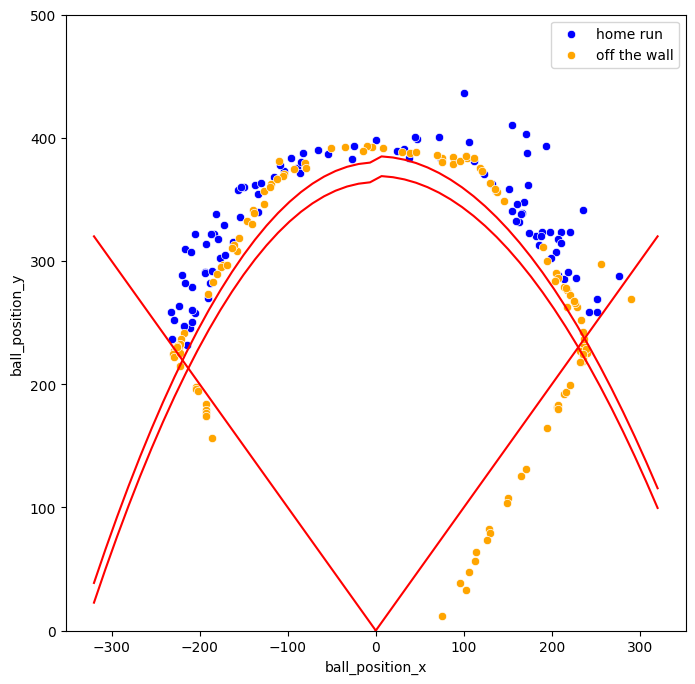

None

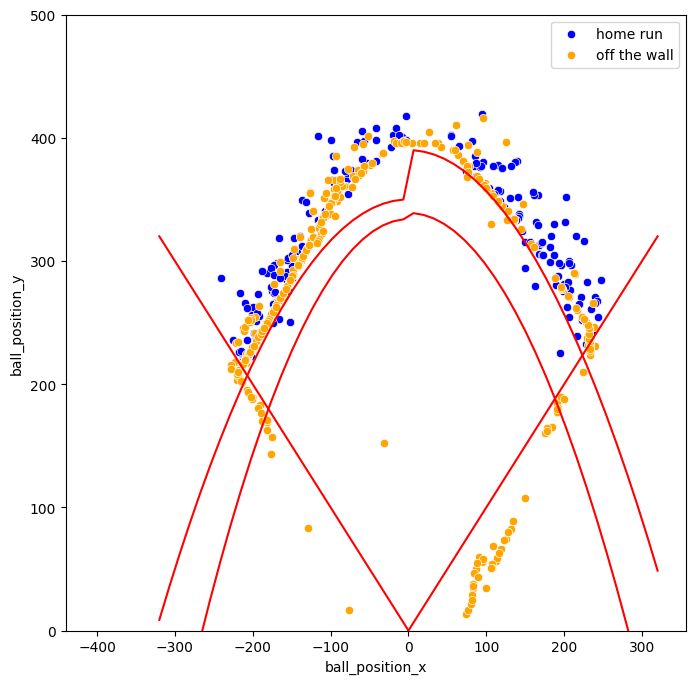

None

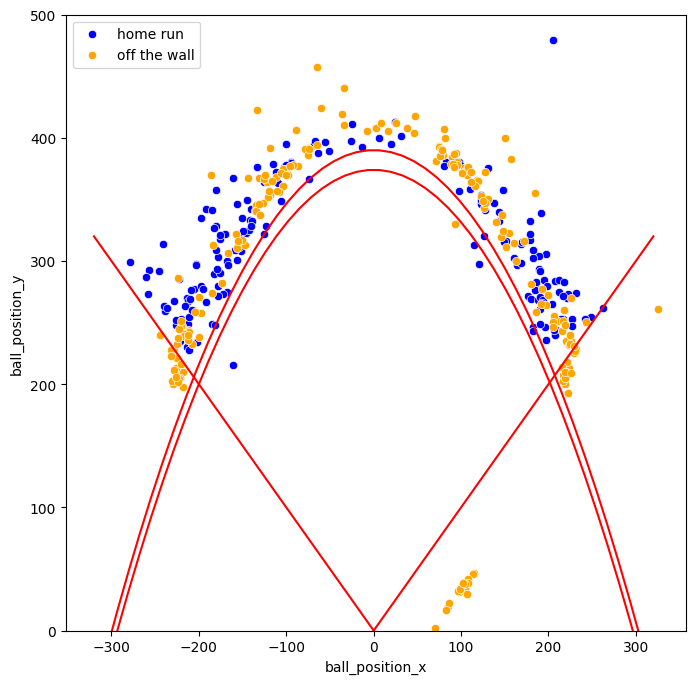

None

In [20]:
display(stadium_walls(event_pos_ball, 'QEA'))
display(stadium_walls(event_pos_ball, 'RZQ'))
display(stadium_walls(event_pos_ball, 'YJD'))

Thoughts on the stadiums:
* there are some weird outliers (e.g., RZQ has the worst examples of this) --> makes it harder to accurately come up with the outfield dimensions

In [21]:
event_pos_ball[(event_pos_ball['home_team'] == 'RZQ') 
               & (event_pos_ball['ball_position_x'].between(-100, 0)) 
               & (event_pos_ball['ball_position_y'].between(100, 200)) 
               & (event_pos_ball['event_code_name'] == 'ball deflection off of wall')
               ]

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,home_team,away_team,year,day,event_code_name,player_position_name,field_x_7,field_y_7,field_x_8,field_y_8,field_x_9,field_y_9,ball_position_x,ball_position_y,ball_position_z
93983,y1_d063_HCI_RZQ,43,12,43,1407057,255,10,RZQ,HCI,year_1,day_063,ball deflection off of wall,"ball event with no player (e.g., ball bounce)",-92.6112,271.7172,14.7963,312.9606,133.4244,227.1207,-30.7953,151.8696,0.866001


In [118]:
def get_hr_wall_y(x: float) -> bool:
    return np.where(x<0, -((1/200) * x**2) + 380, -((1/235) * x**2) + 385)

## Looking at missing data and understanding why this data **IS** missing

In [22]:
def info_table(df: pd.DataFrame) -> pd.DataFrame:
    """
    Displays information about the dataframe with # of missing values, unique numbers, datatypes, etc.
    
    Arguments: Dataframe
    """
    df = df.copy()
    dtype = df.dtypes
    num_unique = df.T.apply(lambda x: x.nunique(), axis=1)
    nan_total = df.isnull().sum()
    nan_percent = (df.isnull().sum()/df.isnull().count()*100)
    quality_df = pd.concat([nan_total, nan_percent, num_unique, dtype], axis=1, keys=['total_NaNs', 'NaN%', 'num_unique', 'dtypes'])
    display(quality_df)

In [23]:
info_table(game_events.merge(player_pos_transformed, on=['game_str', 'timestamp','play_id'], how='left'))

,total_NaNs,NaN%,num_unique,dtypes
game_str,0,0.000000,274,object
play_id,0,0.000000,441,int64
at_bat,0,0.000000,110,object
play_per_game,0,0.000000,441,int64
timestamp,0,0.000000,247612,int64
player_position,0,0.000000,15,int64
event_code,0,0.000000,12,int64
home_team,0,0.000000,3,object
away_team,0,0.000000,74,object
year,0,0.000000,2,object


In [ ]:
game_events.merge(player_pos_transformed, on=['game_str', 'timestamp','play_id'], how='left')[game_events.merge(player_pos_transformed, on=['game_str', 'timestamp','play_id'], how='left')['field_x_7'].isna()]